# Préparez des données pour un organisme de santé publique

## Santé publique France

![Santé Publique France](data/images/Sante-publique-France-logo.png)

L'agence "Santé publique France" a lancé un appel à projets pour rendre les données de santé plus accessibles. L’agence souhaite faire explorer et visualiser des données, pour que ses agents puissent les exploiter.


## Open Food Facts

![Open Food Facts](data/images/OpenFoodFacts.png)

À l’aide des données d’Open Food Facts, nous réaliserons une première exploration et visualisation des données, afin que les agents puissent ensuite s’appuyer sur nos résultats.

### Importations

Importation de bibliothèques et des paramètres.

In [1]:
# Manipulation de données
import warnings
from IPython import get_ipython
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
import seaborn as sns

# Afficher toutes les sorties de cellule
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = 'all'

# ipython = get_ipython()

# extension de chargement automatique
# if 'autoreload' not in ipython.extension_manager.loaded:
#     %load_ext autoreload

# %autoreload 2

warnings.filterwarnings('ignore')

### Fonctions

Fonctions commune

In [2]:
# Calculer le nombre de lignes d'un dataframe spécifique
def get_rows(df):
    rows = df.shape[0]
    return rows


# Retourner les 10 premiers enregistrements par nom de colonne
def get_top_10(df, column_name):
    df_result = df.groupby([
        column_name
    ]).size().reset_index(name='Nombre').sort_values('Nombre',
                                                     ascending=False).head(10)

    rows = get_rows(df)
    df_result['Pourcentage'] = df_result['Nombre'] / rows * 100

    return df_result.copy()


# Compter le nombre de lignes vides pour un dataframe spécifique.
def get_empty_rows(df, column_name):
    return df.query(str(column_name) + '.isnull()').count()


# Afficher le graphique en barre avec le nombre
def show_plot(df, column_name):
    df_plot = df.loc[:, [column_name, 'Nombre']].set_index(
        column_name)['Nombre'].copy()

    plt.figure(figsize=(15, 10))

    sns.set(style="whitegrid")
    g = sns.barplot(df_plot, df_plot.index, orient='h')

    plt.title('Les plus grands ' + column_name, fontsize=20)
    plt.xlabel("Nombre d'occurrences", fontsize=14)
    plt.ylabel(column_name, fontsize=14)

    # Afficher le nombre à droite du graphique à barres
    for i, v in enumerate(df_plot.values.tolist()):
        g.text(v + 3, i + .25, str(v), color='black', fontweight='normal')

    plt.show()


# Imprimer les principaux éléments de statistiques
def print_stats(df, column_name):
    total_rows = get_rows(df)
    empty_rows = str(df[column_name].isna().sum())
    perc = int(empty_rows) * 100 / int(total_rows)
    print("Nombre d'enregistrements vides pour " + str(column_name) + ': ' +
          str(empty_rows) + ' (' + str(perc) + '%)')
    print(df[column_name].agg(['nunique', 'count', 'size']))

# COMPRENDRE LES DONNÉES

Le but de cette partie est de charger et de comprendre les données fournies par Open Food Facts. Nous aimerions comprendre l'exhaustivité et la fiabilité de ces données.

(https://fr.openfoodfacts.org/guide-pour-les-producteurs)

### Chargement des données
Nous souhaitons charger les données et diviser les fichiers en sous-catégories. Nous aimerions vérifier la taille/forme des ensembles de données et comprendre quelles colonnes pourraient être utilisées pour les agents de Santé publique France. Identifier les lacunes, les NaN. D'une manière ou d'une autre, nous aimerions comprendre la qualité globale des données.

### Qui sont les contributeurs
Nous aimerions vérifier qui sont les contributeurs, qui contribue le plus, si nous pouvons faire confiance à la source et si nous pouvons trouver des références sur le net.

### Quelles sont les marques
Nous voulons vérifier si tous les produits sont assignés à une marque et si toutes ces marques existent (vérification croisée avec wikipedia par exemple).

### Quels sont les pays
Nous voudrions vérifier si tous les produits sont assignés à un Pays (Countries).
Nous n'avous besoins que de produits vendu en France.
Comme nous suspectons des doublons et des données non normalisées, ces valeurs doivent être nettoyées.

### Quelle est l'origine des produits ?
Nous aimerions vérifier si tous les produits sont affectés à une Origine (Pays).
Comme nous suspectons des doublons et des données non normalisées, ces valeurs doivent être nettoyées.

### Quelles sont les catégories principales
Nous cherchons à savoir quelles sont les catégories principales (nombre/pourcentage/vide).

### Vérifier s'il y a d'autres anomalies dans les données
Nous rechercherons des doublons, des aberrations, des produits non alimentaires, etc.

<div class="alert alert-warning">
Veuillez noter que le fichier a été téléchargé depuis Internet et non depuis OpenClassRooms de manière à assurer la mise à jour et le suivi des données.</div>

Cet ensemble de données contient la valeur nutritive des aliments pour plus de 1 700 000 produits alimentaires provenant du monde entier.

![Open Food Facts](data/images/prince.jpg)

Chargement du jeu de données téléchargé à partir de https://static.openfoodfacts.org/data/fr.openfoodfacts.org.products.csv

In [3]:
# Chemin par défaut des données
data_path = 'data/'

In [4]:
# Lire le dossier
df = pd.read_csv(data_path + 'fr.openfoodfacts.org.products.csv',
                 sep="\t",
                 low_memory=False)

## Taille et forme
Contrôle de la taille et de la forme d'Open Food Facts

In [5]:
print('Open Food Facts contient ' + str(get_rows(df)) + ' produits et ' +
      str(df.shape[1]) + ' colonnes')

Open Food Facts contient 1741534 produits et 184 colonnes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741534 entries, 0 to 1741533
Columns: 184 entries, code to carnitine_100g
dtypes: float64(122), int64(2), object(60)
memory usage: 2.4+ GB


In [7]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'abbreviated_product_name', 'generic_name',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=184)

<AxesSubplot:ylabel='None'>

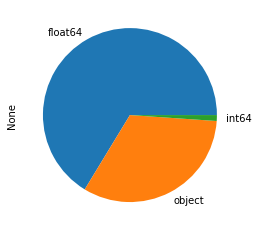

In [8]:
df.dtypes.value_counts().plot.pie()

In [9]:
df.count()

code                  1741534
url                   1741534
creator               1741530
created_t             1741534
created_datetime      1741534
                       ...   
choline_100g               41
phylloquinone_100g       1712
beta-glucan_100g           31
inositol_100g              46
carnitine_100g             20
Length: 184, dtype: int64

In [10]:
df.isnull().sum().sort_values()

code                                           0
url                                            0
created_t                                      0
created_datetime                               0
last_modified_t                                0
                                          ...   
water-hardness_100g                      1741534
no_nutriments                            1741534
allergens_fr                             1741534
cities                                   1741534
ingredients_that_may_be_from_palm_oil    1741534
Length: 184, dtype: int64

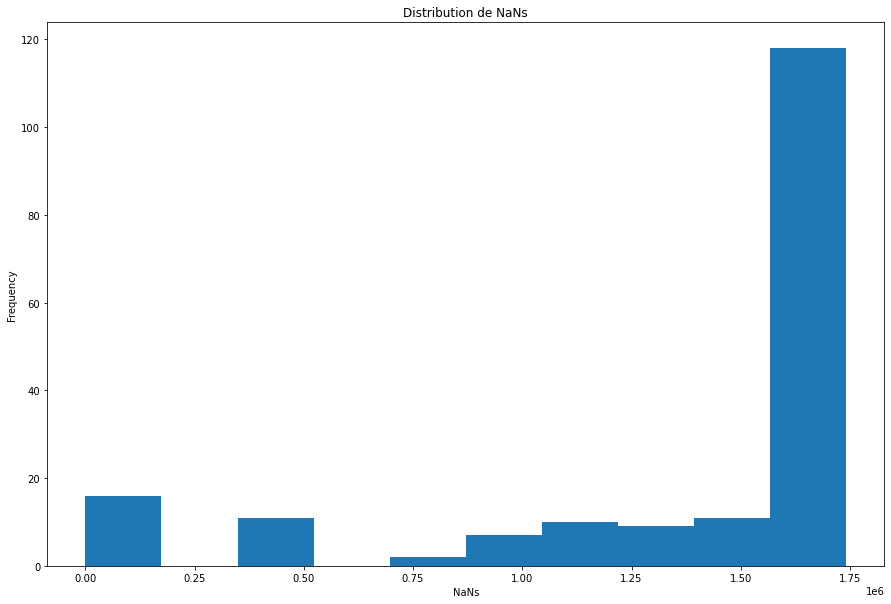

In [11]:
df.isnull().sum().plot(kind='hist', figsize=(15, 10))
plt.title('Distribution de NaNs')
plt.xlabel('NaNs')

plt.show()

### Nettoyage de base sécurisé

Nous pouvons en toute sécurité supprimer les lignes (individus) et les colonnes (variables) sans données ou doublons s'il y en a.

In [12]:
nrows, ncols = df.shape

# Supprimer les lignes sans données.
df.dropna(how='all', inplace=True)

# Supprimer les colonnes sans données.
empty_variables = df.columns[df.isnull().sum() == df.shape[0]]
df.dropna(how='all', axis=1, inplace=True)

# Supprimer les valeurs en double
duplicates_count = df.duplicated().sum()
df.drop_duplicates(inplace=True)

print("Nombre de lignes vides supprimées: {}".format(nrows - df.shape[0]))
print('Nombre de colonnes vides supprimées: {}'.format(len(empty_variables)))
print('Colonnes supprimées:\n{}'.format(empty_variables))
print('Nombre de doublons supprimés: {}'.format(duplicates_count))
print('\nDimensions du jeu de données: {}'.format(df.shape))

Nombre de lignes vides supprimées: 1
Nombre de colonnes vides supprimées: 6
Colonnes supprimées:
Index(['cities', 'allergens_fr', 'no_nutriments', 'ingredients_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil', 'water-hardness_100g'],
      dtype='object')
Nombre de doublons supprimés: 1

Dimensions du jeu de données: (1741533, 178)


### Compréhension des données

#### Identification des variables d'objets

Ayons un meilleur aperçu de l'ensemble de données. Parce qu'il y a beaucoup de variables, nous traiterons séparément les variables objet et numériques.

In [13]:
# Augmenter le nombre de lignes par défaut affichées par pandas
pd.set_option('max_rows', 178)

# Obtenir un résumé pour les variables d'objet seulement
df.describe(include='object').T

,count,unique,top,freq
code,1741533,1741530,7798049540559,2
url,1741533,1741530,http://world-fr.openfoodfacts.org/produit/3770...,2
creator,1741529,13382,kiliweb,974818
created_datetime,1741533,1492133,2020-04-23T17:22:07Z,28
last_modified_datetime,1741533,1368983,2021-02-27T09:03:05Z,145
product_name,1664013,1095758,Aceite de oliva virgen extra,1243
abbreviated_product_name,3223,3192,"6x27,5cl tourtel twi",7
generic_name,113017,82309,Pâtes alimentaires de qualité supérieure,283
quantity,453621,35265,500 g,19622
packaging,280313,50396,Kunststoff,6369



Nous pouvons remarquer que :

- Pour rappel, nous avons 1 741 534 lignes, cela signifie donc que nous avons beaucoup de valeurs manquantes dans nos données.
- Les colonnes `code` (code barre) ou `url` peuvent être utilisées comme _clé/index unique_. Nous devons également éliminer les lignes dont le code est manquant ou double.
- Le `creator` le plus fréquent est _kiliweb_. Nous enquêterons dessus plus tards. Avec ses  13 382 `creator`, cet ensemble de données est probablement une agrégation de plusieurs sources de données avec leur propre structure, ce qui pourrait expliquer pourquoi l'ensemble de données semble très clairsemé.
- Nous avons des informations temporelles. `created_datetime` et `last_modified_datetime` doivent être converties vers le type `datetime`.
- Les variables sont souvent déclinées en trois versions : `x`(ex.: categories), `x_lang` (ex.: categories_fr), `x_tags` (ex.: categories_tags). 
Notons le préfixe `en:` (ex.: en:france), cela signifie que nous avons probablement plusieurs langues dans les données.
- Les variables `states` et `states_fr` donnent quelques informations sur l'état d'avancement de chaque observation.

Nous pouvons également identifier quelques thèmes :

- Origine, Marques, Etiquettes, Pays
- Emballage, Code Emb, Lieux de fabrication
- Ingrédients, Allergènes, Traces, Additifs
- Huile de palme

Et quelques variables de classification intéressantes :

- `categories, main_category`
- `pnns_groups`
- `nutriscore_grade` (pourrait être une variable cible pour construire un modèle)

#### Aperçu des contributeurs


Les 10 premiers contributeurs (en nombre et en pourcentage)
                          creator  Nombre  Pourcentage
6594                      kiliweb  974818    55.974707
12530             usda-ndb-import  169827     9.751581
9512   openfoodfacts-contributors  162061     9.305652
9558            org-database-usda  134539     7.725320
3574                       elcoco   33179     1.905161
2920              date-limite-app   31189     1.790893
5440                          inf   11513     0.661084
9510           openfood-ch-import   11455     0.657754
11138                    sebleouf   10309     0.591950
10218                  prepperapp    9964     0.572140


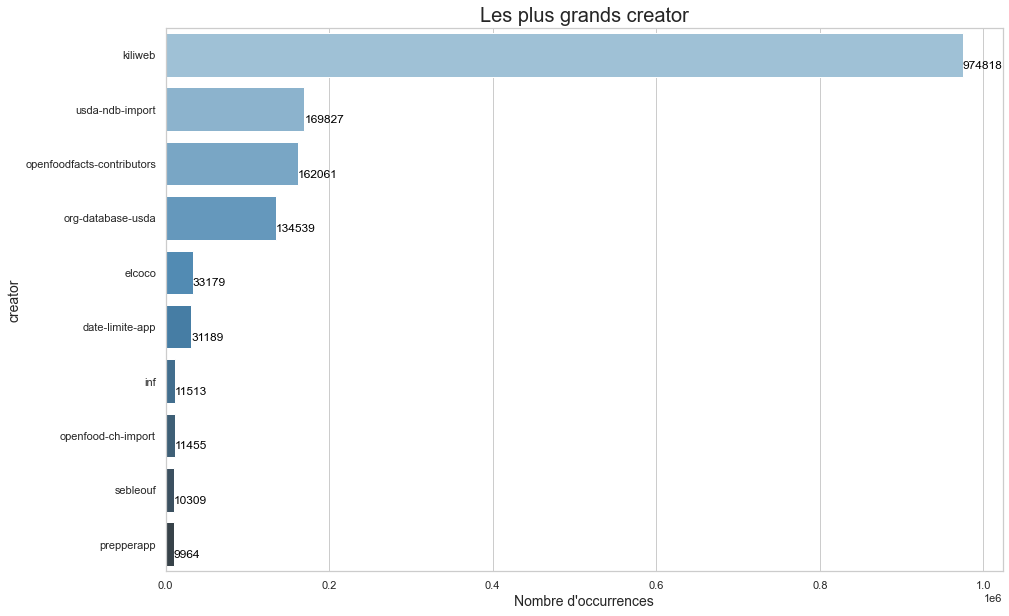

Nombre d'enregistrements vides pour creator: 4 (0.00022968269909327013%)
nunique      13382
count      1741529
size       1741533
Name: creator, dtype: int64


In [14]:
# Obtenir les 10 premiers contributeurs
df_10_contributors = get_top_10(df, 'creator')

# Afficher le résultat
print('\nLes 10 premiers contributeurs (en nombre et en pourcentage)')
print(df_10_contributors)
show_plot(df_10_contributors, 'creator')

# Afficher des informations sur les observations vides
print_stats(df, 'creator')

Après avoir chargé et explorer légèrement les nous pouvons commencer à identifier qui sont les contributeurs : https://fr.openfoodfacts.org/contributeurs

Pouvons-nous leur faire confiance ? 

Une grande partie des données a été générée par kiliweb. Approximativement 55%. Qui est-ce ?

Kiliweb semble être une agence web en France. Une grande moitié des données est fourni par cette agence. Il serait préférable d'enquêter dessus dans la partie analyse.

#### Aperçu du moment où les produits ont été créés par les contributeurs

<AxesSubplot:title={'center':'Quand les produits ont-ils été créés ?'}, xlabel='mod_datetime'>

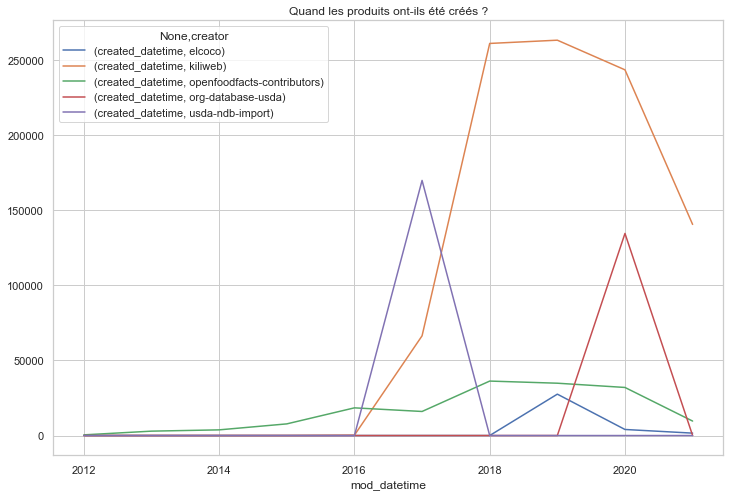

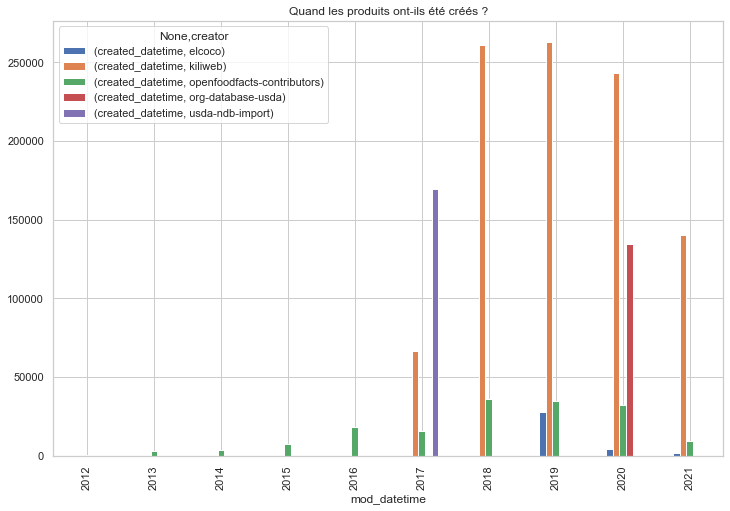

In [15]:
top_5_creators = df.loc[(df['creator'] == 'kiliweb') |
                        (df['creator'] == 'usda-ndb-import') |
                        (df['creator'] == 'openfoodfacts-contributors') |
                        (df['creator'] == 'org-database-usda') |
                        (df['creator'] == 'elcoco')][[
                            'creator', 'created_datetime'
                        ]]

top_5_creators['mod_datetime'] = top_5_creators['created_datetime'].apply(
    lambda x: x[0:4])
top_5_creators.drop('created_datetime', axis=1)

mod_pivot = pd.pivot_table(top_5_creators,
                           index=top_5_creators['mod_datetime'],
                           columns='creator',
                           aggfunc=len,
                           fill_value=0)
mod_pivot.plot(kind="line",
               figsize=(12, 8),
               title="Quand les produits ont-ils été créés ?")
mod_pivot.plot(kind="bar",
               figsize=(12, 8),
               title="Quand les produits ont-ils été créés ?")

Jusqu'à présent, nous pouvons voir que Kiliweb est le contributeur le plus actif et ajoute continuellement des produits. C'est le contributeur le plus actif. La plupart des produits sont donc probablement principalement de France. 
Nous pouvons déjà supposer, sur la base des principaux contributeurs, que les produits français prédominent.

usda-ndb-import, qui est le 'United States Department of Agriculture' semble ne plus contribuer à la base de données open food facts et n'a été importé qu'une seule fois.

La communauté ouverte des contributeurs d'openfoodfacts semble s'agrandir au fil des années. La diversité des contributeurs peut conduire à des données non concordantes.

#### Les marques
Informations générales sur les marques


Les 10 premières marques (nombres et pourcentages)
              brands  Nombre  Pourcentage
20495      Carrefour   14320     0.822264
7410          Auchan   11241     0.645466
15064        Bonarea    6960     0.399648
127017             U    6185     0.355147
31793       Delhaize    4995     0.286816
52197      Hacendado    4904     0.281591
21246         Casino    4502     0.258508
90856         Nestlé    4340     0.249206
71810   Leader Price    4204     0.241397
27020           Coop    3469     0.199192


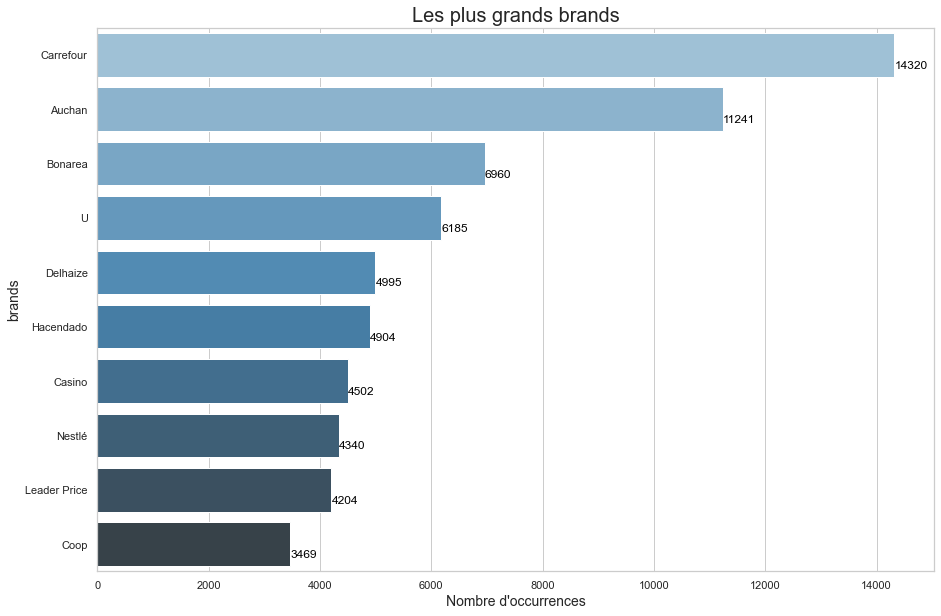

Nombre d'enregistrements vides pour brands: 832770 (47.81821533097564%)
nunique     160641
count       908763
size       1741533
Name: brands, dtype: int64


In [16]:
# Obtenir le top 10 des marques
df_10_brands = get_top_10(df, 'brands')

# Afficher le résultat
print('\nLes 10 premières marques (nombres et pourcentages)')
print(df_10_brands)
show_plot(df_10_brands, 'brands')

# Afficher des informations sur les enregistrements vides
print_stats(df, 'brands')

48% des produits ne sont associés à aucune marque. En outre, les 6 plus grandes marques d'Open Food Facts sont Français.

Il semble que, comme décrit ci-dessus avec les contributeurs, la communauté française, à travers kiliweb, est le contributeur le plus important. Cela peut expliquer pourquoi il y a tant de produits assignés à la France.


Top 10 countries (Counts & Percentage)
          countries_fr  Nombre  Pourcentage
2215            France  719896    41.336914
3987        États-Unis  343086    19.700230
2092           Espagne  196916    11.307050
3193            Italie   61439     3.527869
123          Allemagne   59186     3.398500
972           Belgique   47760     2.742411
3758            Suisse   45303     2.601329
3557       Royaume-Uni   38649     2.219252
1741            Canada   27515     1.579930
2219  France,Allemagne   11781     0.676473


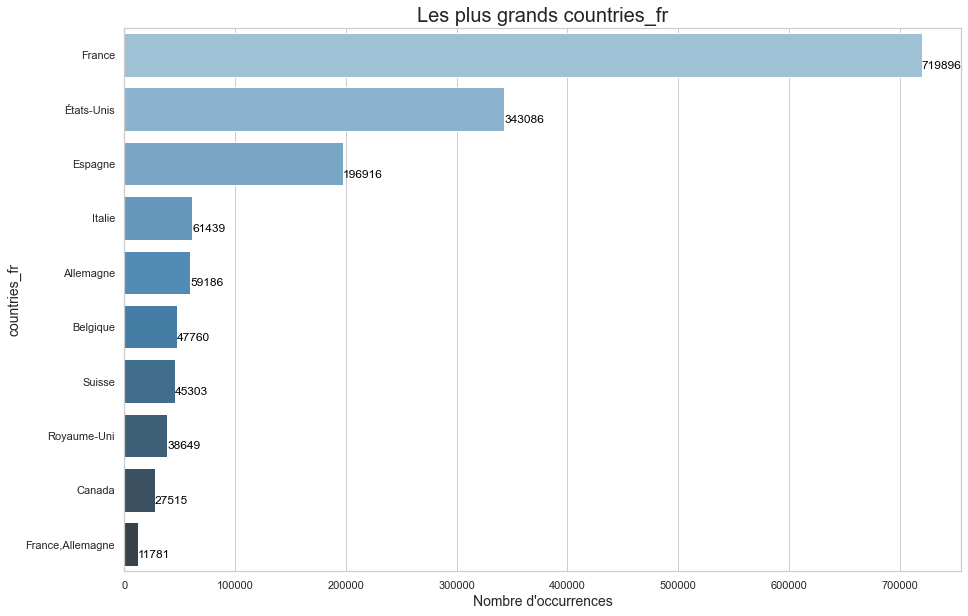

Nombre d'enregistrements vides pour countries_fr: 5482 (0.3147801391073267%)
nunique       4005
count      1736051
size       1741533
Name: countries_fr, dtype: int64


In [17]:
# Obtenir le top 10 de countries_fr
df_10_countries_fr = get_top_10(df, 'countries_fr')

# Afficher le résultat
print('\nTop 10 countries (Counts & Percentage)')
print(df_10_countries_fr)
show_plot(df_10_countries_fr, 'countries_fr')

# Afficher des informations sur les NaNs
print_stats(df, 'countries_fr')

Nous découvrons ici le même comportement que l'analyse précédente. La plupart des produits sont attribués à la France, ce qui était attendu puisque le principal contributeur est kiliweb une agence web française. Ceci est cohérent, surtout après l'analyse des contributeurs et des marques ci-dessus.

Même si la plupart des produits ont été assignés à un pays, 5482 produits ne sont liés à aucun pays et qu'il y a 4005 pays.

Jusqu'à présent, il semble que les pays contiennent une liste de pays et non un pays unique comme en témoigne la 10e ligne "France,Allemagne".

De plus, la plupart des produits sont liés à un ou deux pays seulement, ce qui est très suspect. Nous pourrions par exemple supposer sans le moindre doute que cette confiture à la fraise de l'Oregon https://fr.openfoodfacts.org/produit/0011110901422/oregonstrawberry-kroger attribué à la France a été fondée aux USA puisque c'est là où se situe l'Oregon et qu'il est fabriqué par Kroger https://fr.wikipedia.org/wiki/Kroger.

<img src="https://static.openfoodfacts.org/images/products/001/111/090/1422/front_fr.4.full.jpg"></img>

Très probablement, ce produit est vendu en France et a été répertorié comme produit français. Mais nous pouvons être sûrs que cette confiture est également vendu aux Etats-Unis, peut-être sous un autre nom de produit.

Jusqu'à présent, nous pouvons conclure que ce champ pays doit être utilisé avec précaution pour fournir une analyse de produits français ou vendu en France aux agents de Santé Publique France.


Top 10 des origines (nombres et pourcentages)
               origins  Nombre  Pourcentage
3267            France   18902     1.085366
6058            México    1886     0.108295
8875  Union Européenne    1603     0.092045
2709            España    1450     0.083260
4877            Italie    1332     0.076484
2638           Espagne    1242     0.071316
2235       Deutschland    1076     0.061785
8951  Union européenne     988     0.056732
4989             Italy     809     0.046453
4848            Italia     807     0.046338


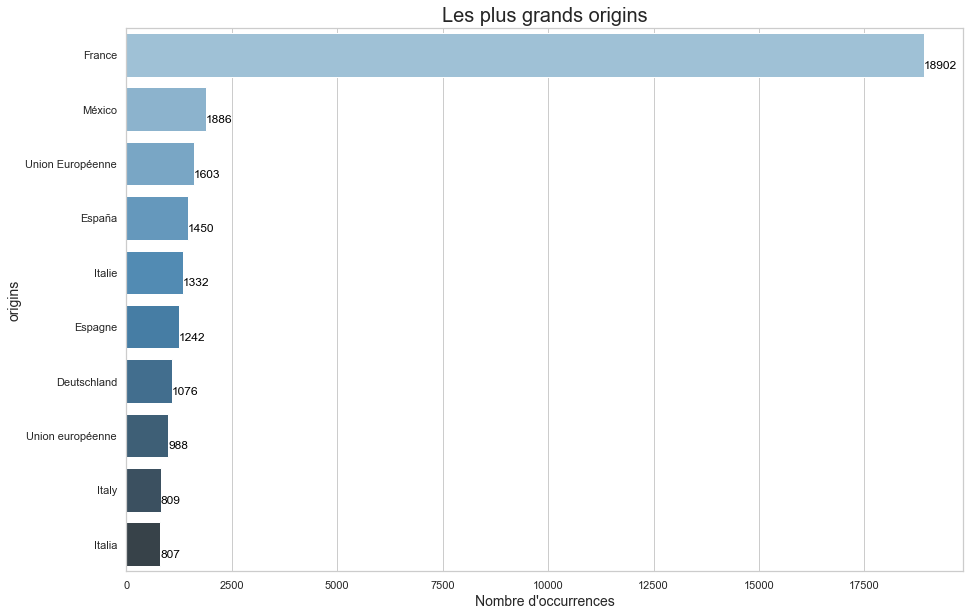

Nombre d'enregistrements vides pour origins: 1666000 (95.66284417234701%)
nunique      12389
count        75533
size       1741533
Name: origins, dtype: int64


In [18]:
# Obtenir le top 10 des origines
df_10_origins = get_top_10(df, 'origins')

# Afficher le résultat
print('\nTop 10 des origines (nombres et pourcentages)')
print(df_10_origins)
show_plot(df_10_origins, 'origins')

# Afficher des informations sur les enregistrements vides
print_stats(df, 'origins')

Les origines sont très dénormalisées et peuvent contenir comme valeur un pays une région ou un continent,... 12389 valeurs uniques, c'est beaucoup plus que la liste des pays potentiels.

Cela rend l'utilisation de ce champ difficile.

#### Catégorie principale

Nous cherchons à savoir quelles sont les principales catégories (nombre/pourcentage/NaNs).


Top 10 des principales catégories (nombres et pourcentages)
          main_category_fr  Nombre  Pourcentage
13764               Snacks   32884     1.888221
13040               Sauces   16013     0.919477
3575           Confiseries   15262     0.876354
5866              Fromages   14652     0.841328
1142              Biscuits   14638     0.840524
1609              Boissons    9314     0.534816
4665       Desserts glacés    9238     0.530452
9838                 Pains    8999     0.516729
22489     en:salted-snacks    7684     0.441220
4467   Céréales et dérivés    7402     0.425028


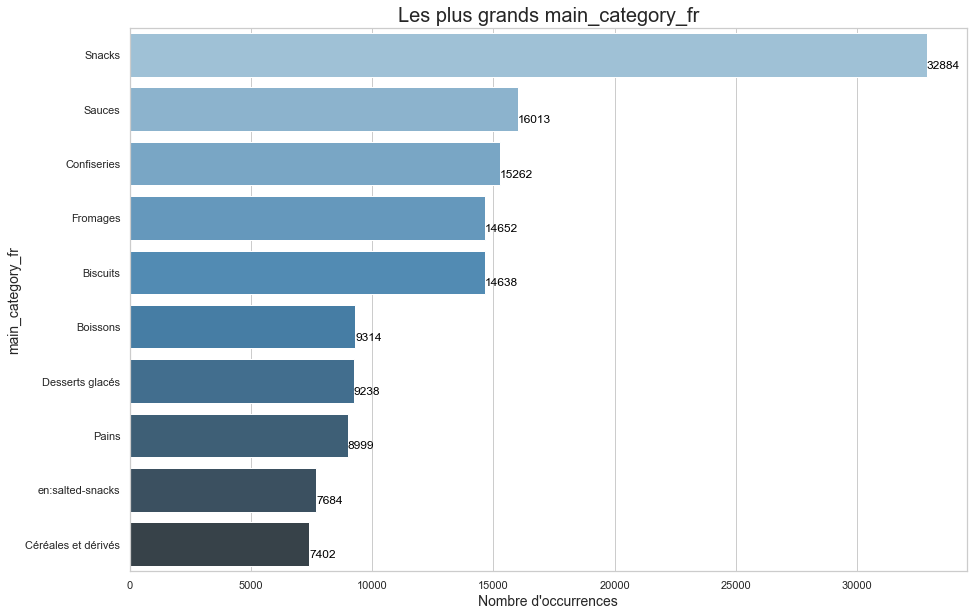

Nombre d'enregistrements vides pour main_category_fr: 905959 (52.020777096959975%)
nunique      28838
count       835574
size       1741533
Name: main_category_fr, dtype: int64


In [19]:
# Obtenir le top 10 Catégorie principale
df_10_main_category_fr = get_top_10(df, 'main_category_fr')

# Show Result
print('\nTop 10 des principales catégories (nombres et pourcentages)')
print(df_10_main_category_fr)
show_plot(df_10_main_category_fr, 'main_category_fr')

# Afficher des informations sur les enregistrements vides
print_stats(df, 'main_category_fr')

Il semble que 52% des produits n'ont pas de catégorie.

#### Identification des variables numériques

In [20]:
# Obtenir une liste pour les variables numériques uniquement
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
created_t,1741533.0,1.550696e+09,4.993390e+07,1.328021e+09,1.518964e+09,1.561572e+09,1.587667e+09,1.618708e+09
last_modified_t,1741533.0,1.585857e+09,2.855156e+07,1.333873e+09,1.576526e+09,1.587663e+09,1.607760e+09,1.618708e+09
serving_quantity,460930.0,2.410585e+16,1.636590e+19,0.000000e+00,2.800000e+01,5.000000e+01,1.130000e+02,1.111111e+22
additives_n,685544.0,2.046187e+00,2.919098e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,4.900000e+01
ingredients_from_palm_oil_n,685544.0,2.062596e-02,1.439338e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
ingredients_that_may_be_from_palm_oil_n,685544.0,6.907799e-02,3.009657e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
nutriscore_score,650486.0,9.182527e+00,8.895505e+00,-1.500000e+01,2.000000e+00,1.000000e+01,1.600000e+01,4.000000e+01
nova_group,599607.0,3.431875e+00,9.636102e-01,1.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
energy-kj_100g,126273.0,5.278689e+37,1.875777e+40,0.000000e+00,4.000000e+02,9.760000e+02,1.617000e+03,6.665559e+42
energy-kcal_100g,1329062.0,6.541628e+06,7.541188e+09,0.000000e+00,1.010000e+02,2.630000e+02,4.000000e+02,8.693855e+12


Nous pouvons identifier quelques thèmes :

- Les macronutriments avec leurs multiples niveaux de décomposition : glucides, lipides, protéines.
- les micronutriments : minéraux, vitamines
- Le score énergétique et nutritionnel (qui pourrait être utilisé comme variable cible pour construire un modèle).

Nous pouvons également remarquer que :

- Nous avons très peu de données pour les niveaux de décomposition. Nous pourrions probablement abandonner toutes ces variables ou les conserver malgré tout pour mener une étude approfondie sur les carences.
- Les données sont normalisées sur 100 grammes. Il y a quelques valeurs négatives et des valeurs supérieures à 100 à nettoyer.
- Le score nutritionnel va de -15 à 40 (cela semble d’après le site santé publique)
- L’énergie est exprimée en kilojoules.

Faisons un peu de nettoyage :

Nous allons supprimer les observations dont les valeurs sont incohérentes. Nous pourrions décider de remplacer les valeurs négatives par 0, étant donné la nature du projet, les observations avec des données incohérentes sont probablement de mauvaises entrées et nous avons aussi plus que suffisamment de données.


### Nettoyage des données

Cette partie, contient toutes les activités de nettoyage des données, effectuées sur le fichier fr.openfoodfacts.org.products.csv. Le but de cette partie est de nettoyer les données et de les enrichir en fonction des activités requises. Qui est, pour rappel, fournir des données de santé plus accessible pour les agents de santé publique.

Avant d'effectuer toute analyse, il est en effet important de disposer d'un ensemble de données consolidées correctes. En effet, nous découvrons que l'ensemble de données nécessite beaucoup d'activités de nettoyage et que la qualité des données est parfois médiocre.

#### Les objets
Nettoyons les données comme indiqué ci-dessus. Nous restons très conservateurs.

In [21]:
# Définir le sous-ensemble de variables dans lequel
# nous ne voulons pas de données manquantes.
subset = [
    'code', 'creator', 'created_datetime', 'last_modified_datetime',
    'product_name', 'states_tags'
]

# Supprimer les lignes avec
# des données manquantes dans ce sous-ensemble.
df.dropna(subset=subset, inplace=True)

# Supprimer les nouvelles variables avec des données
# manquantes qui apparaissent après la suppression précédente.
df.dropna(how='all', axis=1, inplace=True)

print('Forme du jeu de données: {}'.format(df.shape))

Forme du jeu de données: (1664009, 178)


Réduction du nombre de lignes à 1 664 003.

Nous cherchons à savoir s'il y a d'autres anomalies dans les données. Nous examinons la qualité des données pour comprendre ce qui pourrait être utilisé pour une analyse plus approfondie.

Nous avons identifié quelques doublons comme indiqué ci-dessus, qui devraient être nettoyés/supprimés, une fois clairement identifiés.

In [22]:
df[df.duplicated(subset='code')].head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
633814,30383354190402,http://world-fr.openfoodfacts.org/produit/3038...,openfoodfacts-contributors,1608035756,2020-12-15T12:35:56Z,1610702583,2021-01-15T09:23:03Z,basilic,NaN,NaN,...,NaN,NaN,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1015382,3770008983205,http://world-fr.openfoodfacts.org/produit/3770...,r-x,1614201389,2021-02-24T21:16:29Z,1614242412,2021-02-25T08:40:12Z,REMYX VODKA Aquatique,NaN,Vodka,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1389391,7798049540559,http://world-fr.openfoodfacts.org/produit/7798...,openfoodfacts-contributors,1615222625,2021-03-08T16:57:05Z,1615337611,2021-03-10T00:53:31Z,lentejas,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Suppression des doublons dans la colonne code
df.drop_duplicates('code', keep=False, inplace=True)

In [24]:
# Définir code comme index
df.set_index('code', inplace=True)

In [25]:
# Convertir les variables d'objet created_datetime
# et last_modified_datetime en variables de type datetime.
df.created_datetime = pd.to_datetime(df.created_datetime)
df.last_modified_datetime = pd.to_datetime(df.last_modified_datetime)

df.created_datetime.head()

code
0000000000017          2018-06-15 10:38:00+00:00
0000000000031          2018-10-13 21:06:14+00:00
000000000003327986     2019-11-19 15:02:16+00:00
0000000000100          2015-10-11 14:09:21+00:00
00000000001111111111   2019-06-08 18:56:13+00:00
Name: created_datetime, dtype: datetime64[ns, UTC]

#### Les variables numériques
Nettoyons les données comme indiqué ci-dessus.

Nous allons maintenant éliminer toutes les lignes, qui contiennent des valeurs impossibles par définition.

Une inspection des valeurs min et max révèle qu'il y a des erreurs évidentes dans nos données.

In [26]:
# Supprimer les observations dont les
# éléments x_100g ont des valeurs négatives
obs_with_negative_facts = (df.loc[:, 'fat_100g':'chlorophyl_100g'] < 0).any(
    axis=1)
df.drop(df[obs_with_negative_facts].index, inplace=True)

# Supprimer les observations x_100g qui ont une valeur supérieure à 100g
obs_with_facts_over_100 = (df.loc[:, 'fat_100g':'chlorophyl_100g'] > 100).any(
    axis=1)
df.drop(df[obs_with_facts_over_100].index, inplace=True)

# Supprimer les observations dont la somme de
# lipide + glucide + protéine ont une valeur supérieure à 100g
df[(df['fat_100g'] + df['carbohydrates_100g'] + df['proteins_100g']) <= 100]

print('Produit avec la valeur minimale: {}'.format(
    df.describe(include='number').T.loc['fat_100g':'cocoa_100g', 'min'].min()))
print('Produit avec la valeur maximale: {}'.format(
    df.describe(include='number').T.loc['fat_100g':'cocoa_100g', 'max'].max()))
print('Forme du jeu de données: {}'.format(df.shape))

Produit avec la valeur minimale: 0.0
Produit avec la valeur maximale: 100.0
Forme du jeu de données: (1662721, 177)


Au cours de ce processus, nous avons abandonné 761 365 observations.

#### Filtrer les produits disponible en France

In [27]:
countries_filter = df['countries_tags'].astype(dtype='str').str.split(',')
df_fr = df[countries_filter.apply(lambda lang: 'en:france' in lang)]
df_fr.shape

(769290, 177)

Dans cette dataframe nous abandonnons 480 374 observations.

#### Les valeurs manquantes

Regardons plus en détail les valeurs manquantes, l'ensemble de données est très clairsemé mais nous allons en avoir un meilleur aperçu en traçant un histrogramme du pourcentage de valeurs manquantes par variables, empilées par type (objet et nombre) et aussi un histrogramme du pourcentage de valeurs manquantes par observation.

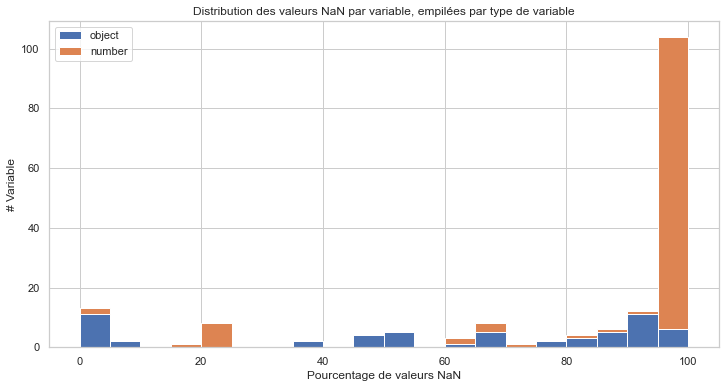

In [28]:
# Distribution des valeurs manquantes par variable,
# empilées par type de variable
nan_counts_object_vars = df_fr.select_dtypes(
    'object').isnull().sum() / df_fr.shape[0] * 100
nan_counts_number_vars = df_fr.select_dtypes(
    'number').isnull().sum() / df_fr.shape[0] * 100

pd.DataFrame({'object': nan_counts_object_vars, 'number': nan_counts_number_vars}) \
  .plot.hist(stacked=True, bins=20, figsize=(12, 6))

plt.xlabel('Pourcentage de valeurs NaN')
plt.ylabel('# Variable')
plt.title(
    'Distribution des valeurs NaN par variable, empilées par type de variable')
plt.show()

Il est clair que nous avons des variables avec des valeurs essentiellement manquantes mais nous devons nous demander ce que signifie avoir des valeurs manquantes dans une variable objet et une variable numérique du point de vue du domaine :

- Les variables objet sont essentiellement des données qui décrivent les produits ou permettent de les classer. À un haut niveau, les valeurs manquantes signifient que la fiche produit est incomplète. Par exemple, si nous sommes intéressés par les groupes de produits, nous travaillerons au mieux avec environ 1/3 de l'ensemble de données.

- La plupart des variables numériques sont des faits alimentaires. Certains faits sont simplement moins actuels que d'autres ; s'il est presque impossible de trouver un produit sans indication sur les graisses, il sera plus difficile d'en trouver un avec du fer par exemple. Étant donné que l'ensemble de données présente les informations sur les aliments sous une forme non empilée, nous disposons de données très éparses. Dans ce cas, les variables présentant un grand nombre de valeurs manquantes ne sont pas synonymes de mauvaises variables, bien au contraire. Si nous voulions analyser les aliments pour bébés à différents âges, ces faits/variables rares seraient probablement très utiles.

Enfin, l'élimination des variables doit être dictée par l'objectif que nous avons. Pour l'analyse que feront les agents, l'idéal est ne pas supprimer de variables du tout, ou utiliser une simple règle de seuil NaN, même si en réalité nous pouvons continuer ce projet en toute sécurité. Nous avons un grand ensemble de données, mais il pourrait être beaucoup plus grand.
Le mieux est la stratégie consistant à construire un nouveau dataframe à partir de la source plutôt que de réduire la forme du dataframe source.

Notez que même 5% de valeurs non nulles dans une variable d'une dataframe de produits vendu en France représentent environ 21 113 observations.

In [29]:
# Voici une fonction pour faciliter l'exploration :
# Obtenir les variables pour lesquelles le pourcentage
# des valeurs manquantes se situe dans la fourchette basse et haute des %.
def get_variables_with_nan_in_range(data, low, high, dtypes):
    if high >= 100:
        high = 100.1

    nan_counts = data.select_dtypes(dtypes).isnull().sum()
    nan_counts_percent = nan_counts / data.shape[0] * 100

    filter = (nan_counts_percent >= low) & (nan_counts_percent < high)
    nan_counts = nan_counts[filter]
    nan_counts_percent = nan_counts_percent[filter]
    counts = data.shape[0] - nan_counts
    counts_percent = 100 - nan_counts_percent

    return pd.DataFrame({
        'nombre': counts,
        'nombre %': counts_percent,
        'nombre de NaN': nan_counts,
        'nombre de NaN %': nan_counts_percent
    })


# Données alimentaires avec NaN
get_variables_with_nan_in_range(df_fr, 0, 95, 'number')

,nombre,nombre %,nombre de NaN,nombre de NaN %
created_t,769290,100.000000,0,0.000000
last_modified_t,769290,100.000000,0,0.000000
serving_quantity,78040,10.144419,691250,89.855581
additives_n,240747,31.294700,528543,68.705300
ingredients_from_palm_oil_n,240747,31.294700,528543,68.705300
ingredients_that_may_be_from_palm_oil_n,240747,31.294700,528543,68.705300
nutriscore_score,275751,35.844870,493539,64.155130
nova_group,202232,26.288136,567058,73.711864
energy-kj_100g,70607,9.178203,698683,90.821797
energy-kcal_100g,590202,76.720353,179088,23.279647


Dans la fourchette 0-95% de valeurs manquantes, nous avons des variables pour les macronutriments (glucides/lipides/protéines) et le premier niveau des minéraux et vitamines les plus courants. Il nous manque l'amidon, les polyols pour le premier niveau de répartition des glucides; la caséine et les protéines sériques pour les protéines.

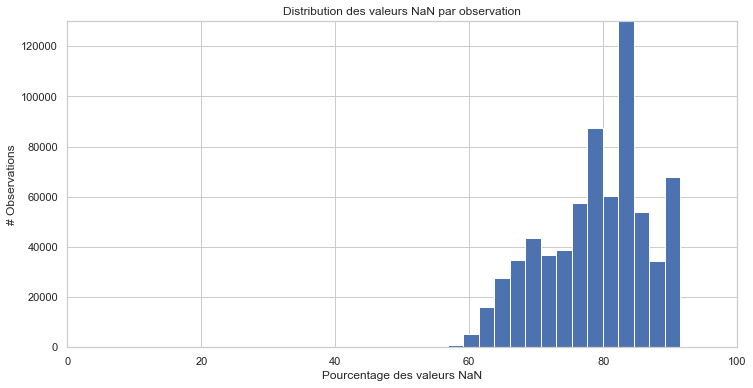

In [30]:
# Distribution des valeurs manquantes par observation
nan_counts_obs = df_fr.isnull().sum(axis=1) / df_fr.shape[1] * 100
nan_counts_obs.hist(bins=20, figsize=(12, 6))

plt.xlim((0, 100))
plt.ylim((0, 130000))
plt.xlabel('Pourcentage des valeurs NaN')
plt.ylabel('# Observations')
plt.title('Distribution des valeurs NaN par observation')
plt.show()

Concernant les valeurs manquantes par observation, il est intéressant de voir ce pic énorme autour de 85% de valeurs manquantes. Surement causé par kiliweb qui domine ce jeu de données.

#### Récapitulatif

En résumé, dans cette première partie, nous avons acquis une meilleure compréhension des données et de leur structure. Nous avons effectué un nettoyage de sécurité et de base. Nous avons décidé de conserver toutes les variables avec les données car les variables présentant un grand nombre de valeurs manquantes ne sont pas synonymes de mauvaises variables et pourront servir pour des analyses.

Dans les sections suivantes, nous construirons des sous-ensembles de données dédiés pour mener nos différentes analyses.

À ce stade, nous disposons d'une base de données source de produits disponibles en France avec laquelle nous pouvons travailler de manière suffisament sereine. Bien sûr, il ne s'agit que d'une première itération de nettoyage et nous devrons nettoyer les données plus en profondeur dans les prochaines sections.

### Enquête et nettoyage en profondeur

Dans cette section, nous allons travailler avec les données, approfondir le nettoyage et enquêter sur trois sujets différents qui semblent indispensables pour permettre aux agents de santé publique de mener correctement leurs analyses :

1. Est-ce que les données sont fiables ? Les réponses pourraient être biaisées et nous n'aurions aucun moyen de le deviner. Qui est exactement kiliweb cette agence web française ? Dans ce premier sujet, nous allons travailler avec `creator`, `created_datetime` et `states_tags` pour avoir une meilleure idée sur la fiabilité des données.

2. Nous allons enquêter sur les allergènes et essayer de savoir quels allergènes sont les plus communs. Comme les données contiennent plusieurs langues, nous allons d'abord construire un dictionnaire pour traduire les allergènes, car les données sur les allergènes sont désordonnées. Il est important que cette variable soit propre pour permettre aux agents de travailler sur l'étiquetage des allergènes qui est un impératif: https://www.economie.gouv.fr/dgccrf/letiquetage-des-allergenes-imperatif-sante-publique

3. Enfin, nous travaillerons également avec des données numériques. Nous étudierons la répartition des macronutriments dans les différentes catégories d'aliments `pnns_groups` et nous répondrons à la question de savoir quels sont les aliments qui ont le ratio le plus élevé de fibres. Ce sera également l'occasion d'utiliser certaines méthodes statistiques pour déterminer si nos résultats sont significatifs ou dus au hasard.

#### Enquete sur les sources de données

##### Sources et collecte des données

D'où viennent les données et comment elles ont été collectées sont les questions auxquelles nous voulons répondre dans cette section. A la fin, le but est d'avoir un esprit critique sur les résultats que nous obtiendrons.

Exemple : Nous avons des données provenant de multiples inventaires de supermarchés contre des produits collectés par des personnes selon leurs propres motivations (avec une application mobile). Dans le premier cas, nous aurions toutes sortes de produits et si les supermarchés ne sont pas des supermarchés alimentaires spécifiques (ex.: aliments bio uniquement), les données ne devraient pas être biaisées. Dans le second cas, où la collecte est le résultat de la motivation des personnes, il est plus probable que les données soient biaisées. Qui s'intéresse aux faits alimentaires, pourquoi et quels produits auraient-ils tendance à acheter et à scanner ? Probablement les personnes qui suivent un régime, les sportifs, etc. Leur choix d'aliments en sera le reflet, tout comme notre ensemble de données. Nous voulons être sûrs que ce n'est pas le cas avec les données que nous fourniront aux agents !

Voyons si pouvons apprendre quelque chose de nouveau de la variable `creator` depuis son nettoyage :


Les 10 premiers contributeurs (en nombre et en pourcentage)
                         creator  Nombre  Pourcentage
3122                     kiliweb  602825    78.361216
4534  openfoodfacts-contributors   64977     8.446360
1419             date-limite-app   21871     2.843011
5657                      tacite    8350     1.085416
5322                    sebleouf    7342     0.954387
4434              nutrinet-sante    4251     0.552587
4533          openfood-ch-import    2598     0.337714
5710                    teolemon    2357     0.306386
5656                     tacinte    2275     0.295727
5571                    stephane    2028     0.263620


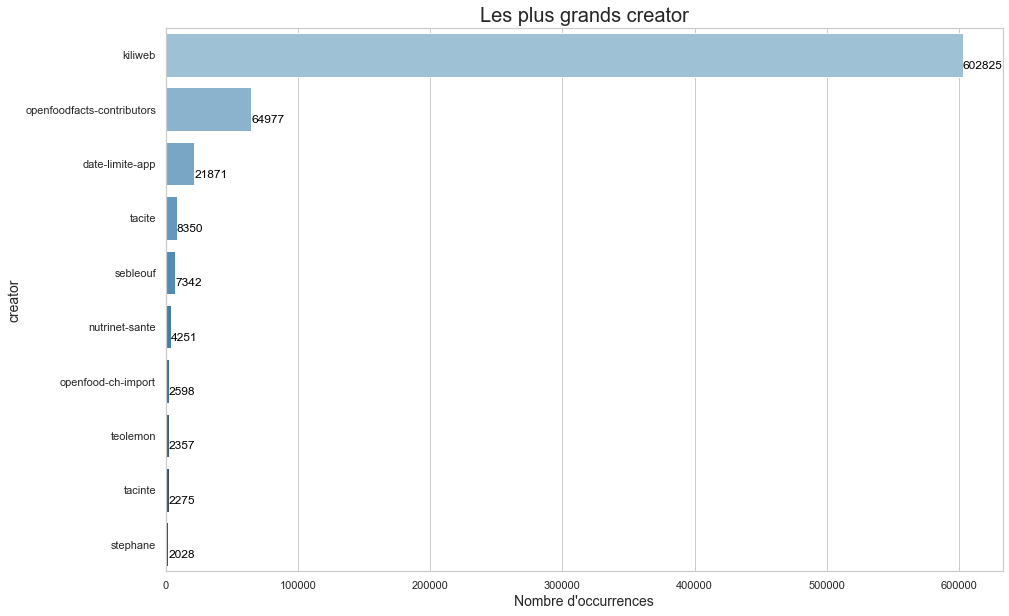

Nombre d'enregistrements vides pour creator: 0 (0.0%)
nunique      6336
count      769290
size       769290
Name: creator, dtype: int64


In [31]:
# Obtenir les 10 premiers contributeurs
df_fr_10_contributors = get_top_10(df_fr, 'creator')

# Afficher le résultat
print('\nLes 10 premiers contributeurs (en nombre et en pourcentage)')
print(df_fr_10_contributors)
show_plot(df_fr_10_contributors, 'creator')

# Afficher des informations sur les observations vides
print_stats(df_fr, 'creator')

Nous constatons que la majorité des données, à quasiment 80% proviennent de kiliweb. En plus de la base de données communautaire `openfoodfacts-contributors`, nous avons également une minorité de données importées de The Food Repo (`openfood-ch-import`), un projet initié par le Digital Epidemiology Lab de l'EPFL. On remarque aussi que les données importé de la base de données nationale sur les nutriments du ministère américain de l'agriculture pour les aliments de marque (`usda-ndb-import`) ont disparu durant le filtrage de produits vendu en France.

Quelques recherches sur le web nous permettent d'identifier les 3 premiers `creator` :

- kiliweb est une startup française qui a développé l'application Yuka qui implémente l'API OpenFoodFacts.
- openfoodfacts-contributors sont des contributeurs anonymes d'OpenFoodFacts
- date-limite-app est également une application mobile qui implémente l'API OpenFoodFacts.
- les autres contributeurs sont des contributeurs enregistrés (Stéphane est probablement le fondateur d'OpenFoodFacts).

Cela signifie également que la distribution de nos données (valeurs manquantes et non manquantes) reflétera majoritairement la structure de la base de données de kiliweb. De plus, nous observerons probablement que la plupart des produits seront originaire de la France et minoritairement de la Suisse car Yuka et OpenFoodFacts sont des projets français et le Food Repo est un projet suisse et que nous avons perdu `usda-ndb-import` durant le processus de filtration.

Concernant la manière dont les données sont collectées :

- Yuka reverse via l'agence Kiliweb les contributions de ses utilisateurs.
- Les données du Food Repo sont collectées par des volontaires lorsque les distributeurs donnent accès à leurs magasins. La communauté peut améliorer les données du site web en répondant aux questions sur les données manquantes (toujours le poids/volume).
- Les données d'OpenFoodFacts sont collectées à partir de l'application mobile qui permet uniquement d'envoyer des photos mais pas de créer/modifier des faits alimentaires. Le site web permet de modifier les faits alimentaires, mais uniquement si l'on est enregistré.

Nous avons probablement beaucoup d'observations avec des valeurs manquantes car il est possible que des personnes qui utilisent l'application, prennent des photos mais ne remplissent jamais la fiche produit sur le site web.

Aussi, il semble qu'OpenFoodFacts n'utilise pas encore l'OCR ou des technologies plus avancées (apprentissage profond, réseau neuronal) pour automatiser le processus à partir de la photo des ingrédients et des faits, mais des projets en ce sens sont en cours. (cf : https://wiki.openfoodfacts.org/OCR/Roadmap)

Au sujet de la fiabilité, les données proviennent des inventaires des magasins, des initiatives des fabricants et des produits scannés par des personnes. L'inconvénient que nous pourrions avoir et que nous avons remarqué précédemment, c'est l'origine des pays biaisé car, à ce stade, il semble probable que la majorités de nos données soient des produits marqué comme français (ex: vu plus haut, la confiture d'origine américaine marqué comme française).

Vérifions cela en commençant par créer une variable `source` à partir de `creator` et vérifions si notre hypothèse sur les pays est correcte.

Dans la suite du projet, nous utiliserons quelques fonctions utilitaires :

In [32]:
# Obtenir les principales occurrences
def get_top_occurencies(df, cols, n=10):
    count = df.groupby(cols).size().sort_values(ascending=False)
    count_percent = round(count / df.shape[0] * 100, 2)
    return pd.DataFrame({'count': count, 'count %': count_percent}).head(n)


# Obtenir les occurrences les plus importantes contenant
# une expression rationnelle ou une chaîne de caractères.
def get_top_occurencies_containing(df, col, value, n=10):
    occurences = get_top_occurencies(df, col, df.shape[0])
    return occurences[occurences.index.str.contains(
        r'{}'.format(value))].head(n)

In [33]:
# Contrôler s'il existe d'autres données
# provenant de bases de données externes
get_top_occurencies_containing(df_fr,
                               'creator',
                               value='import|load|dump|database|db|bd|base|\-',
                               n=20)

,count,count %
creator,,
openfoodfacts-contributors,64977,8.45
date-limite-app,21871,2.84
nutrinet-sante,4251,0.55
openfood-ch-import,2598,0.34
usda-ndb-import,1110,0.14
moon-rabbit,511,0.07
big-brother,474,0.06
systeme-u,439,0.06
systeme-u-off,376,0.05


Visiblement, il n'y a pas d'autres sources de données externes.

Hormis kiliweb qui represente à lui seul quasiment 80% du jeu de données, les applications mobiles qui implémentent l'API d'Open Food Facts peuvent être considérées comme des contributeurs openfoodfacts.

Créons une variable source, avec ce mappage :

- kiliweb => kiliweb
- openfood-ch-import => foodrepo
- usda-ndb-import => usda (vérifier s'il existe encore des traces)
- Tous les autres => openfoodfacts

In [34]:
# Créer une variable source à partir du mappage suivant
mapping = {
    'kiliweb': 'kiliweb',
    'openfood-ch-import': 'foodrepo',
    'usda-ndb-import': 'usda'
}
df_fr['source'] = df_fr.creator.map(mapping)
df_fr['source'].fillna(value='openfoodfacts', inplace=True)

get_top_occurencies(df_fr, 'source')

,count,count %
source,,
kiliweb,602825,78.36
openfoodfacts,162757,21.16
foodrepo,2598,0.34
usda,1110,0.14


Confirmons notre hypothèse sur la distribution des pays par source.

In [35]:
# Pays les plus courants regroupés par source
get_top_occurencies(df_fr, ['source', 'countries_fr'], n=10)

count  count %
source        countries_fr                      
kiliweb       France             570257    74.13
openfoodfacts France             127840    16.62
kiliweb       France,Espagne       8105     1.05
openfoodfacts France,Allemagne     7959     1.03
kiliweb       Belgique,France      4518     0.59
openfoodfacts Belgique,France      4470     0.58
              France,Suisse        4242     0.55
kiliweb       France,Allemagne     3710     0.48
              France,Suisse        2439     0.32
              France,États-Unis    2301     0.30

L'hypothèse est confirmée, nous avons bien une majorité d'origine française accompagné d'une minorité Suisse et autres.

Pour résoudre cela il pourra être possible, par exemple, de scrapper une base de données de marques accompagné de leurs origines pour corriger cette variable.

Un autre indicateur de la fiabilité de la donnée serait de visualiser son état grace à la variable `states_fr`. Grâce à elle nous allons nous faire une idée des informations que nous pouvons obtenir des différentes sources de données.

#### Analyse de l'état de la données

La variable `states_fr` fournit le statut de chaque observation et pourrait être un bon moyen de réduire la taille de notre ensemble de données en fonction de nos besoins pour l'analyse future.

Dans cette section, nous allons :

- Créer des variables indicatrices pour chaque état complété.
- Analyser si chaque source de données tend à fournir des données pour toutes les variables ou seulement une partie d'entre elles et dans quelle proportion.

In [36]:
# Exemples de valeurs de states_fr
get_top_occurencies(df_fr, 'states_fr', 5)

,count,count %
states_fr,,
"À compléter,Informations nutritionnelles complétées,Ingrédients à compléter,Date limite à compléter,Code emballeur à compléter,Caractéristiques à compléter,Catégories à compléter,Marques à compléter,Emballage à compléter,Quantité à compléter,Nom du produit complété,Photos à valider,Photos envoyées",112933,14.68
"À compléter,Informations nutritionnelles complétées,Ingrédients à compléter,Date limite à compléter,Code emballeur à compléter,Caractéristiques à compléter,Catégories à compléter,Marques complétées,Emballage à compléter,Quantité à compléter,Nom du produit complété,Photos à valider,Photos envoyées",39252,5.10
"À compléter,Informations nutritionnelles à compléter,Ingrédients à compléter,Date limite à compléter,Code emballeur à compléter,Caractéristiques à compléter,Catégories à compléter,Marques à compléter,Emballage à compléter,Quantité à compléter,Nom du produit complété,Photos à valider,Photos envoyées",35852,4.66
"À compléter,Informations nutritionnelles complétées,Ingrédients à compléter,Date limite à compléter,Code emballeur à compléter,Caractéristiques à compléter,Origines à compléter,Catégories à compléter,Marques à compléter,Emballage à compléter,Quantité à compléter,Nom du produit complété,Photos à valider,Photo de l'emballage non sélectionnée,Photo de la nutrition non sélectionnée,Photo des ingrédients non sélectionnée,Photo de face sélectionnée,Photos envoyées",27947,3.63
"À compléter,Informations nutritionnelles complétées,Ingrédients à compléter,Date limite à compléter,Code emballeur à compléter,Caractéristiques à compléter,Catégories complétées,Marques à compléter,Emballage à compléter,Quantité à compléter,Nom du produit complété,Photos à valider,Photos envoyées",25243,3.28


Nous voulons construire un DataFrame avec chaque état complété comme variable indicatrice, donc nous devons :

1. Extraire tous les états pour chaque observation (les états sont séparés par une virgule)
2. Table pivot pour avoir une variable par état.
3. Supprimer les variables qui correspondent aux états non terminés

In [37]:
# 1. Extraire tous les états (retourne une série multi-indexée
# avec les états extraits comme valeur, <code + match> | state)
# Lors de l'extraction, nous donnons le nom "états" au groupe extrait
# Note : Nous aurions pû aussi utiliser : pd.Series.str.get_dummies(sep=',')
df_states = df_fr.states_fr.str.extractall(r"(?P<états>[^,]+)")
df_states.head(8)

états
code          match                                         
0000000000017 0                                  À compléter
              1      Informations nutritionnelles complétées
              2                      Ingrédients à compléter
              3                      Date limite à compléter
              4                   Code emballeur à compléter
              5                 Caractéristiques à compléter
              6                       Catégories à compléter
              7                          Marques à compléter

In [38]:
# 2. Faire une table pivot afin d'avoir
# une variable pour chaque état individuel.
# (nous devons réinitialiser l'index et créer
# une valeur de colonne pour faire pivoter la table)
df_states.reset_index(inplace=True)
df_states['values'] = 1
df_states = df_states.pivot_table(index='code',
                                  columns='états',
                                  values='values',
                                  fill_value=0)
df_states.head()

états,Caractéristiques complétées,Caractéristiques à compléter,Catégories complétées,Catégories à compléter,Code emballeur complété,Code emballeur à compléter,Complet,Date limite complétée,Date limite à compléter,Emballage complété,...,Photos à valider,Quantité complétée,Quantité à compléter,Vérifié,en:front-photo-not-selected,en:ingredients-photo-not-selected,en:nutrition-photo-not-selected,en:packaging-photo-not-selected,À compléter,À vérifier
code,,,,,,,,,,,,,,,,,,,,,
0000000000017,0,1,0,1,0,1,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0
0000000000031,0,1,0,1,0,1,0,0,1,0,...,1,1,0,0,0,0,0,0,1,0
0000000000100,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
00000000001111111111,0,1,1,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
0000000000123,0,1,0,1,0,1,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0


In [39]:
# 3. Conserver uniquement les états complétés
# (supprimer l'état vide et les états contenant "à", "not" et "non")
columns_to_drop = df_states.columns[df_states.columns.str.contains(
    r'à|À|not|non')]
df_states.drop(axis=1, columns=columns_to_drop, inplace=True)
df_states.head()

états,Caractéristiques complétées,Catégories complétées,Code emballeur complété,Complet,Date limite complétée,Emballage complété,Informations nutritionnelles complétées,Ingrédients complétés,Marques complétées,Nom du produit complété,Origines complétées,Photo de face sélectionnée,Photo de l'emballage sélectionnée,Photo des ingrédients sélectionnée,Photos envoyées,Photos validées,Quantité complétée,Vérifié
code,,,,,,,,,,,,,,,,,,
0000000000017,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
0000000000031,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
0000000000100,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0
00000000001111111111,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
0000000000123,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [40]:
# Joindre la variable source
df_states = df_states.join(df_fr.source, how='inner')

In [41]:
df_states.groupby(df_fr.source).sum()

,Caractéristiques complétées,Catégories complétées,Code emballeur complété,Complet,Date limite complétée,Emballage complété,Informations nutritionnelles complétées,Ingrédients complétés,Marques complétées,Nom du produit complété,Origines complétées,Photo de face sélectionnée,Photo de l'emballage sélectionnée,Photo des ingrédients sélectionnée,Photos envoyées,Photos validées,Quantité complétée,Vérifié
source,,,,,,,,,,,,,,,,,,
foodrepo,522,1694,197,250,458,968,2560,2351,2446,2598,116,1145,16,1061,2598,633,2384,0
kiliweb,31575,227740,44827,14045,38436,64010,519599,130162,266549,602825,6034,179259,2850,91138,595517,73836,118693,647
openfoodfacts,68242,123416,40049,36347,51050,107806,126852,102603,143099,162756,11726,60438,2982,49560,148415,46641,135483,619
usda,137,1008,7,74,85,199,1110,1103,1106,1110,13,189,4,147,1052,137,258,0


In [42]:
# Proportion en % des observations avec des états complétés par source
pd.set_option('max_columns', None)
df_states_prop = df_states.groupby(
    df_fr.source).agg(lambda x: round(x.sum() / x.shape[0] * 100, 2))
df_states_prop

,Caractéristiques complétées,Catégories complétées,Code emballeur complété,Complet,Date limite complétée,Emballage complété,Informations nutritionnelles complétées,Ingrédients complétés,Marques complétées,Nom du produit complété,Origines complétées,Photo de face sélectionnée,Photo de l'emballage sélectionnée,Photo des ingrédients sélectionnée,Photos envoyées,Photos validées,Quantité complétée,Vérifié
source,,,,,,,,,,,,,,,,,,
foodrepo,20.09,65.20,7.58,9.62,17.63,37.26,98.54,90.49,94.15,100,4.46,44.07,0.62,40.84,100.00,24.36,91.76,0.00
kiliweb,5.24,37.78,7.44,2.33,6.38,10.62,86.19,21.59,44.22,100,1.00,29.74,0.47,15.12,98.79,12.25,19.69,0.11
openfoodfacts,41.93,75.83,24.61,22.33,31.37,66.24,77.94,63.04,87.92,100,7.20,37.13,1.83,30.45,91.19,28.66,83.24,0.38
usda,12.34,90.81,0.63,6.67,7.66,17.93,100.00,99.37,99.64,100,1.17,17.03,0.36,13.24,94.77,12.34,23.24,0.00


kiliweb semble être le jeu de donnée le moins complet. Et openfoodfacts semble être le plus complet. Observons cela sur un graphique.

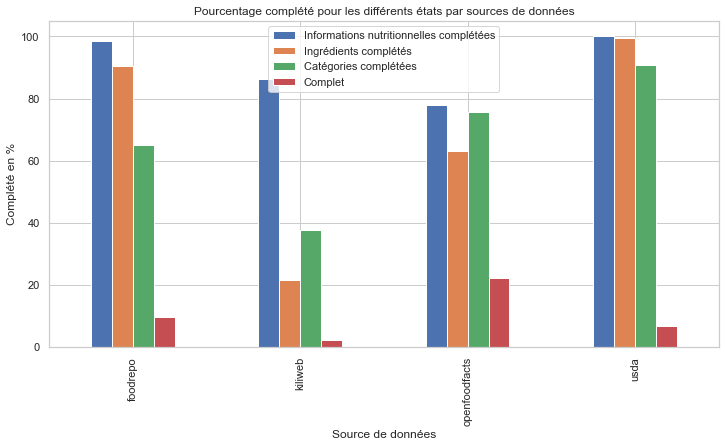

In [43]:
# Dessiner un graphique pour les faits, les ingrédients,
# les catégories et les états complétés par source.
df_states_prop.loc[:, [
    'Informations nutritionnelles complétées', 'Ingrédients complétés',
    'Catégories complétées', 'Complet'
]].plot.bar(figsize=(12, 6))

plt.xlabel('Source de données')
plt.ylabel('Complété en %')
plt.title(
    "Pourcentage complété pour les différents états par sources de données")
plt.show()

Comme nous pouvons le constater, de manière générale les sources ne fournissent que le nom du produit, la marque, les ingrédients et les données nutritionnelles. Cela reflète bien le processus de collecte dans lequel les fabricants fournissent les données.

Graphiquement, la source openfoodfacts semble bien être la source la plus complète des 4 (en rouge).

Dans une prochaine section, nous classerons les produits alimentaires par `pnns_group`.

Terminons cette section en comparant le nombre de valeurs manquantes entre kiliweb et les contributeurs (openfoodfacts). Cette comparaison peut servir d'indice sur la qualité du jeu de données de kiliweb qui est dominant comparé à celle des autres contributeurs. Par exemple, est-ce que Yuka applique un traitement particulier sur les données avant de les transmettre à kiliweb ? Nous affichons la distribution des valeurs manquantes par observations empilées par `source`.

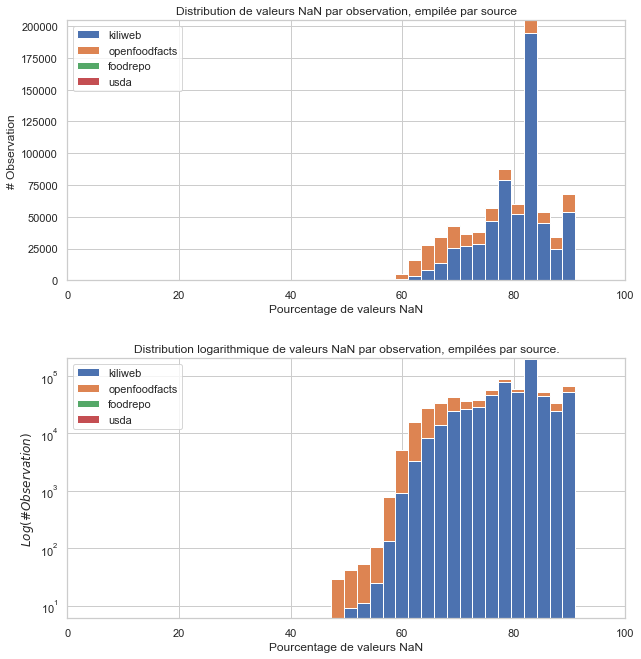

In [44]:
# Distribution de valeurs NaN sur les lignes empilées par source.
dict = {}
for source in get_top_occurencies(df_fr, 'source').index:
    df_source = df_fr[df_fr.source == source]
    dist = df_source.isnull().sum(axis=1) / df_source.shape[1] * 100
    dict[source] = dist

fig, ax = plt.subplots(nrows=2, ncols=1)
pd.DataFrame(dict).plot.hist(ax=ax[0], stacked=True, bins=20, figsize=(10, 11))
pd.DataFrame(dict).plot.hist(ax=ax[1],
                             logy=True,
                             stacked=True,
                             bins=20,
                             figsize=(10, 11))
plt.subplots_adjust(hspace=0.3)
ax[0].set_xlim(0, 100)
ax[1].set_xlim(0, 100)
ax[0].set_ymargin(1)
ax[0].set_xlabel('Pourcentage de valeurs NaN')
ax[1].set_xlabel('Pourcentage de valeurs NaN')
ax[0].set_ylabel('# Observation')
ax[1].set_ylabel('$Log(\# Observation)$')
ax[0].set_title(
    'Distribution de valeurs NaN par observation, empilée par source')
ax[1].set_title(
    'Distribution logarithmique de valeurs NaN par observation, empilées par source.'
)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
plt.show()

Nous voyons clairement que le pic est causé par la source de données kiliweb et les contributeurs d'open et cela confirme notre intuition. Le graphique logarithmique donne une meilleure idée de l'état d'avancement des données du projet openfoodfacts.

Dans ce point de vue, proportionnellement, la source openfoodfacts semble contenir plus de NaN que kiliweb.

Les parties précédentes étaient trop techniques et proches de la base de données mais nous connaissons nos données et leur raison d'être maintenant. Plongeons dans la dimension temporelle et enquêtons sur le groupe de travail à l'origine du projet openfoodfacts pour savoir s'il s'agit d'un projet sain ou d'un projet opensource en voie de disparition.

#### Nombre de produits ajoutés chaque mois et évolution au fil du temps

Nous allons utiliser la variable `created_datetime` pour procéder aux analyses suivantes :

- Quand l'intégration de kiliweb a débuté ?
- Observer le nombre de produits ajoutés dans la base de données openfoodfacts chaque mois.
- La croissance du nombre de produits dans la base de données openfoodfacts sur la durée de notre jeu de données.

In [45]:
# Vérifier quand l'intégration de la base de données kiliweb a été faite.
df_fr.loc[df_fr.source == 'kiliweb'].groupby(
    df_fr.created_datetime.dt.date).size()

created_datetime
2016-03-22      1
2016-05-23      1
2016-05-30      2
2016-06-01      4
2016-06-02      2
             ... 
2021-04-14    350
2021-04-15    263
2021-04-16    346
2021-04-17    395
2021-04-18      2
Length: 1644, dtype: int64

Nous pouvons voir que kiliweb a été inclus dans l'ensemble de données en mars 2016, soit 5 ans après la création d'Open Food Fact, et fourni quotidiennement de plus en plus de données jusqu'à présent.

Visualisons le nombre de produits ajoutés chaque mois dans la base de données openfoodfacts. Nous devons d'abord construire une série temporelle avec le nombre de produits créés chaque jour :

In [46]:
# Nombre de produits créés chaque jour
counts_per_day = df_fr[df_fr.source == 'openfoodfacts'].groupby(
    df_fr.created_datetime.dt.date).size()

# Définir l'index comme un index de date
counts_per_day.index = pd.to_datetime(counts_per_day.index)

# Remplir le trou dans les données (jours manquants) avec 0 produits créés.
counts_per_day = counts_per_day.asfreq('D', fill_value=0)

In [47]:
# Rééchantillonner la série temporelle pour obtenir le nombre d'éléments créés par mois.
counts_per_month = counts_per_day.resample('M').sum()
counts_per_month.head()

created_datetime
2012-01-31      1
2012-02-29     12
2012-03-31    142
2012-04-30    139
2012-05-31    371
Freq: M, dtype: int64

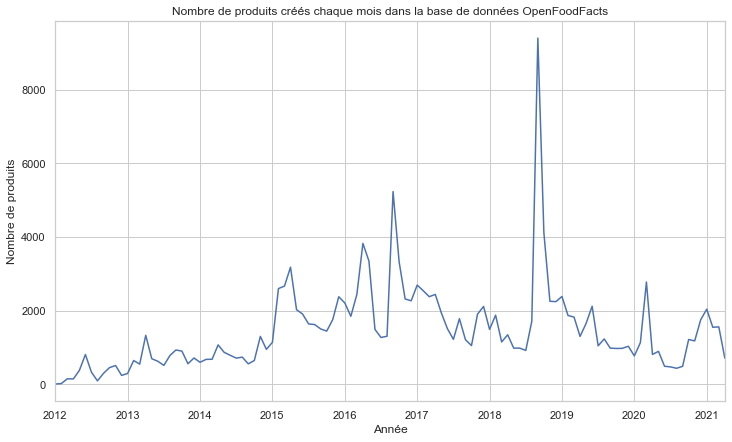

In [48]:
# Tracez le nombre de produits créés chaque mois.
counts_per_month.plot(figsize=(12, 7))
plt.xlabel('Année')
plt.ylabel('Nombre de produits')
plt.title(
    'Nombre de produits créés chaque mois dans la base de données OpenFoodFacts'
)
plt.show()

Même sans compter kiliweb, le projet Openfood fact est en bonne santé. Une somme cumulative du nombre de produits sur la ligne de temps nous donnera une meilleure visualisation.

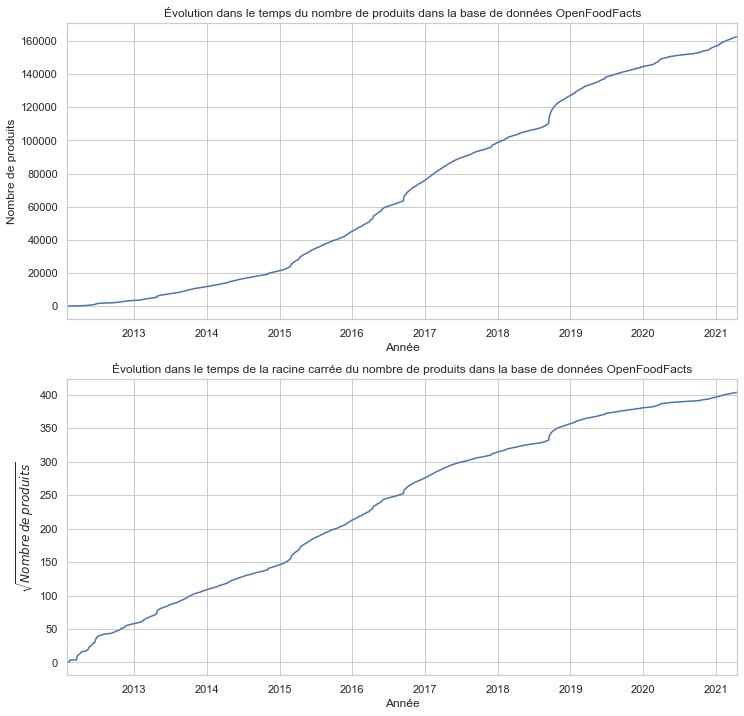

In [49]:
# Tracer la somme cumulée du nombre de produits dans le temps et aussi sa racine carrée.
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
counts_per_day.cumsum().plot(ax=ax1)
np.sqrt(counts_per_day.cumsum()).plot(ax=ax2)
ax1.set_xlabel('Année')
ax2.set_xlabel('Année')
ax1.set_ylabel('Nombre de produits')
ax2.set_ylabel('$\sqrt{Nombre\:de\:produits}$')
ax1.set_title(
    'Évolution dans le temps du nombre de produits dans la base de données OpenFoodFacts'
)
ax2.set_title(
    'Évolution dans le temps de la racine carrée du nombre de produits dans la base de données OpenFoodFacts'
)
plt.show()

On constate que la racine carrée du nombre de produits dans la base de données croît linéairement dans le temps.
Le nombre de produits dans la base de données suit une tendance quadratique.

#### Résumé

Ceci clôt notre première analyse thématique. Elle était définitivement plus technique que scientifique, mais nous avons appris beaucoup de choses sur nos données.

Le projet openfoodfacts est un projet sain qui intéresse les gens et j'espère qu'ils amélioreront la manière dont les données sont collectées, avec des technologies qui pourraient améliorer la qualité des données de manière automatisée.

### Analyse des allergènes

Dans cette analyse, nous allons nous concentrer sur les allergènes et essayer de trouver les allergènes les plus courants.

Commençons par extraire un DataFrame avec les variables requises

In [50]:
# Construirir un DataFrame avec les variables requises
dfallergens = df_fr.loc[df_fr.allergens.notnull(),
                        ['product_name', 'allergens', 'source']].copy()

print('Forme du DataFrame: {}'.format(dfallergens.shape))
dfallergens.head()

Forme du DataFrame: (86464, 3)


,product_name,allergens,source
code,,,
0000000000100,moutarde au moût de raisin,en:mustard,openfoodfacts
0000000001199,Solène céréales poulet,"en:eggs,en:mustard",kiliweb
0000000002264,Baguette Poitevin,"en:gluten,en:milk",kiliweb
0000000003827,Suedois saumon,"en:fish,en:gluten,en:milk",kiliweb
0000000004794,Fromage blanc à la creme de marron,en:milk,kiliweb


In [51]:
# Afficher les données sur les allergènes pour avoir une idée du nettoyage à effectuer.
dfallergens.allergens.head(10)

code
0000000000100                   en:mustard
0000000001199           en:eggs,en:mustard
0000000002264            en:gluten,en:milk
0000000003827    en:fish,en:gluten,en:milk
0000000004794                      en:milk
0000000005272    en:gluten,en:sesame-seeds
0000000005470            en:eggs,en:gluten
0000003075647                  en:soybeans
0000005016                 en:milk,en:nuts
0000005018                         en:none
Name: allergens, dtype: object

Impossible de le remarquer dans cet aperçu, cependant les données ne sont pas propres.

Exemple :
- Parenthèses incomplètes
- Mauvaise écriture des allergènes
- Doublons
- "en:Lait"
- "fr:—-o.alités gustatives. \"
- gt40ai,gt40ba,gt40bo,gt40bp,gt40bs,gt40cn...
- "a eviter (d'après c gouget),e2 troubles digestifs/nausées/contrarie la vitamine b/mutagéne/,e3 interdit en australie/dangereux pour les jeunes enfants/troubles de la coagulation du sang/vomissement/diarrhées/crampes abdominales ou musculaires etc,elimine le calcium,maux de tête,test sur anima endommagement des chromosomes etc"

Les données sont désordonnées, beaucoup de doublons, de synonymes pour le même type d'allergènes, de langues multiples (français, anglais, mais beaucoup d'autres comme de l'Espagnole), certaines sont en majuscules, etc.

Nous allons aborder la préparation des données en cinq étapes :

1. Nettoyage des données par manipulation de texte : tout en minuscules, suppression des espaces et autres.
2. Extraction des allergènes individuels pour obtenir un DataFrame avec un allergène par observation (donc plusieurs observations par produits).
3. Construction d'un dictionnaire avec la traduction et les synonymes des allergènes à partir de ce jeu de données : https://github.com/openfoodfacts/openfoodfacts-server/blob/main/taxonomies/allergens.txt
4. Traduire nos données et supprimer les doublons après traduction.
5. Trouver les allergènes les plus courants.

#### Nettoyage des données

In [52]:
# Tout en minuscules
dfallergens['allergens_c'] = dfallergens.allergens.str.lower()

# Suppression des espaces blancs
dfallergens.allergens_c = dfallergens.allergens_c.str.strip()

# Remplacer les espaces multiples par un seul espace.
dfallergens.allergens_c = dfallergens.allergens_c.str.replace(r"\s+", " ")

# Supprimer les espaces après les virgules
dfallergens.allergens_c = dfallergens.allergens_c.str.replace(r",\s+", ",")

# Suppression de certains caractères spéciaux
dfallergens.allergens_c = dfallergens.allergens_c.str.replace(
    r"[\*|\?|\.]", "")
# Suppression de l'indication des langues
dfallergens.allergens_c = dfallergens.allergens_c.str.replace(r"..:", "")

# TODO : Réaliser un regex pour supprimer les erreurs de backspaces et de parenthèses
# Cette méthode est provisoire
dfallergens = dfallergens.drop([
    '3222476083982', '3564707139809', '3368955876369', '3256227361081',
    '3256220365796', '3256220365796', '3256225722563'
])

In [53]:
# Vérifier le résultat après le nettoyage
dfallergens.allergens_c.tail()

code
9780141185187                                 crustaceans,gluten
98227389                                                    milk
9876754344551    eggs,gluten,milk,nuts,peanuts,biscuit spéculoos
98797554                                             gluten,milk
9900000001926                          gluten,milk,nuts,soybeans
Name: allergens_c, dtype: object

#### Extraction des allergènes

Nous voulons un DataFrame avec un allergène par observation.

In [54]:
# Extraire les allergènes (une observation par code et par allergène, multi-index = code + match )
df_allergens = dfallergens.allergens_c.str.extractall(r"(?P<allergen>[^,]+)")

# Réinitialiser l'index
df_allergens.reset_index(inplace=True)

# Supprimer la colonne créée automatiquement : match
df_allergens.drop('match', axis=1, inplace=True)

# Supprimer les doublons
df_allergens.drop_duplicates(inplace=True)

df_allergens.head()

,code,allergen
0,0000000000100,mustard
1,0000000001199,eggs
2,0000000001199,mustard
3,0000000002264,gluten
4,0000000002264,milk


Il nous manque le nom du produit et la source, fusionnons les deux dataframes.

In [55]:
# Définir 'code' comme index
df_allergens.set_index('code', inplace=True)

# Fusionner les DataFrame pour avoir un allergène
# par observation avec la description du produit.
df_allergens = df_allergens.merge(dfallergens.loc[:,
                                                  ['product_name', 'source']],
                                  on='code')
df_allergens.head()

,allergen,product_name,source
code,,,
0000000000100,mustard,moutarde au moût de raisin,openfoodfacts
0000000001199,eggs,Solène céréales poulet,kiliweb
0000000001199,mustard,Solène céréales poulet,kiliweb
0000000002264,gluten,Baguette Poitevin,kiliweb
0000000002264,milk,Baguette Poitevin,kiliweb


#### Construire un dictionnaire des taxonomies des allergènes

Nos données sont maintenant prêtes à être traduites, nous devons maintenant construire un dictionnaire pour traduire les allergènes et remplacer les différents synonymes par leurs taxonomies correspondantes. Le GitHub d'OpenFoodFact fournit les taxonomies à cette url : https://github.com/openfoodfacts/openfoodfacts-server/tree/main/taxonomies

Sur cette page, on peut voir les différentes taxonomies : fr:gluten, fr:crustacés, fr:œufs, etc. avec différents synonymes dans de nombreuses langues différentes.

Note : Il nous est aussi possible de reconstruire les allergènes grâce aux ingrédients à l'aide du fichier "allergens.result.txt"

In [56]:
# Récupération du fichier contenant les taxonomies d'allergènes
taxonomies = requests.get(
    'https://raw.githubusercontent.com/openfoodfacts/openfoodfacts-server/main/taxonomies/allergens.txt'
)
taxonomies = str(taxonomies.text)

Les différentes taxonomies d'allergènes sont séparées par des lignes vides.
Nous pouvons construire une liste en séparant le texte avec ce séparateur, et construire un dataframe à partir de la liste.

In [57]:
# Supprimer le flag "stopwords" au début du fichier
taxonomies = re.sub(r'stopwords.*?\n', '', taxonomies)

# Supprimer l'annotation wikidata à la fin de chaque taxonomie
taxonomies = re.sub(r'wikidata.*', '', taxonomies)

# Supprimer les lignes vides
taxonomies = re.sub(r'^(?:[\t ]*(?:\r?\n|\r))+', '\n', taxonomies)

# Supprimer les commentaires
taxonomies = re.sub(r'\n#.*', '', taxonomies)

# Supprimez les espaces après la virgule.
taxonomies = re.sub(r',\s+', ',', taxonomies)

# Retirer les 3 retours à la ligne successif
taxonomies = re.sub("([ \t]*\n){3,}", "\n\n", taxonomies)

# Retirer les espaces
taxonomies = taxonomies.strip()

# Tout en minuscules
taxonomies = taxonomies.lower()

# Les allergènes avec leurs synonymes et leurs traductions sont séparés par une ligne vide.
taxonomies = taxonomies.split('\n\n')

In [58]:
# Construire un dataframe
taxonomies = pd.DataFrame({'text': taxonomies})
taxonomies.head()

,text
0,"en:none,allergens-free,without allergens,witho..."
1,"en:gluten,cereals containing gluten,barley,bar..."
2,en:oats\nfr:avoine\npt:aveia-comum
3,"en:crustaceans,crab,lobster,crayfish,prawn,shr..."
4,"en:eggs,egg,barn egg,egg whites,egg white,egg ..."


La taxonomie est le premier mot après le drapeau "fr" sur chaque observation. Extrayons-les et remplaçons l'index par ceux-ci

In [59]:
# Extraire la taxonomie principale des allergènes
# du premier mot français jusqu'à la virgule ou le retour à la ligne
taxonomies['allergen'] = taxonomies.text.str.extract(r'fr:([^\n,]+)')

# Définir l'allergène comme index du dataframe.
taxonomies.set_index('allergen', inplace=True)

taxonomies.head()

,text
allergen,
aucun,"en:none,allergens-free,without allergens,witho..."
gluten,"en:gluten,cereals containing gluten,barley,bar..."
avoine,en:oats\nfr:avoine\npt:aveia-comum
crustacés,"en:crustaceans,crab,lobster,crayfish,prawn,shr..."
œufs,"en:eggs,egg,barn egg,egg whites,egg white,egg ..."


Nous devons maintenant extraire chaque langue pour avoir une ligne par allergène et par langue. Les langues sont séparées par un retour à la ligne

In [60]:
# Extract all langages (to have one row per allergen and langages)
allergens_translations = taxonomies.text.str.extractall(
    r'(?P<translations>[^\n]+)')

# Reset index
allergens_translations.reset_index(inplace=True)

# Drop the automatically created match column
allergens_translations.drop(['match'], axis=1, inplace=True)

allergens_translations.head()

,allergen,translations
0,aucun,"en:none,allergens-free,without allergens,witho..."
1,aucun,"fr:aucun,aucune,sans allergènes,sans,pas,pas d..."
2,aucun,"sr:ništa,nijedan,nijedno,bez alergena,nema ale..."
3,gluten,"en:gluten,cereals containing gluten,barley,bar..."
4,gluten,ar:غلوتين


#### Traduction des allergènes
Nous avons maintenant tout pour remplacer les données sources des allergènes par leurs taxonomies correspondantes :

In [61]:
# Fonction qui renvoie la taxonomie de l'allergène
# si elle est trouvée ou sinon l'allergène déjà existant
def get_allergen_translation(x):
    result = allergens_translations[
        allergens_translations.translations.str.contains(x)]
    if result.shape[0] > 0:
        return result.allergen.iloc[0]
    else:
        return x


# Fonction qui renvoie si une taxonomie d'allergène a été trouvée
def has_translation(x):
    result = allergens_translations[
        allergens_translations.translations.str.contains(x)]
    return result.shape[0] > 0


# Ajouter une variable avec la traduction/taxonomie des allergènes
df_allergens['allergen_translation'] = df_allergens.allergen.map(
    get_allergen_translation)

# Ajouter une variable qui indique si une traduction/taxonomie a été trouvée
df_allergens['translated'] = df_allergens.allergen.map(has_translation)

Comme nous pouvons avoir plusieurs synonymes pour la même taxonomie d'allergènes, nous avons probablement de nouveaux doublons après la traduction. Nous devons les supprimer :

In [62]:
# Réinitialiser l'index
df_allergens.reset_index(inplace=True)

# Supprimer les doublons créés par la traduction parce
# qu'un produit a plusieurs synonymes pour le même allergène
df_allergens.drop_duplicates(subset=['code', 'allergen_translation'], inplace=True)

# Capitaliser la traduction de l'allergène
df_allergens.allergen_translation = df_allergens.allergen_translation.str.capitalize()

df_allergens.loc[:, ['code', 'product_name', 'allergen', 'allergen_translation']].head(10)

,code,product_name,allergen,allergen_translation
0,0000000000100,moutarde au moût de raisin,mustard,Moutarde
1,0000000001199,Solène céréales poulet,eggs,Œufs
2,0000000001199,Solène céréales poulet,mustard,Moutarde
3,0000000002264,Baguette Poitevin,gluten,Gluten
4,0000000002264,Baguette Poitevin,milk,Lait
5,0000000003827,Suedois saumon,fish,Crustacés
6,0000000003827,Suedois saumon,gluten,Gluten
7,0000000003827,Suedois saumon,milk,Lait
8,0000000004794,Fromage blanc à la creme de marron,milk,Lait
9,0000000005272,Sandwich solene céréales sicilien,gluten,Gluten


Nous avons maintenant des données intéressantes prêtes à être analysées.

In [63]:
# Calculer le ratio de traduction.
translation_percent = np.round(df_allergens.translated.sum() / df_allergens.shape[0] * 100, 2)

print("Pourcentage de traduction des taxonomies d'allergènes : {}%".format(translation_percent))

Pourcentage de traduction des taxonomies d'allergènes : 92.99%


Nous pourrions améliorer ce pourcentage en traitant la forme plurielle de certains mots. Par exemple, "fromages" n'a pas été traduit par "Lait" car il est au pluriel.

#### Analyse : Les allergènes les plus courants

In [64]:
allergens_occurences = get_top_occurencies(df_allergens[df_allergens.translated], 'allergen_translation', 20)
allergens_occurences

,count,count %
allergen_translation,,
Lait,47758,30.58
Gluten,40739,26.09
Œufs,19155,12.27
Soja,16175,10.36
Arachides,11736,7.52
Crustacés,7221,4.62
Moutarde,5193,3.33
Céleri,4147,2.66
Avoine,1908,1.22


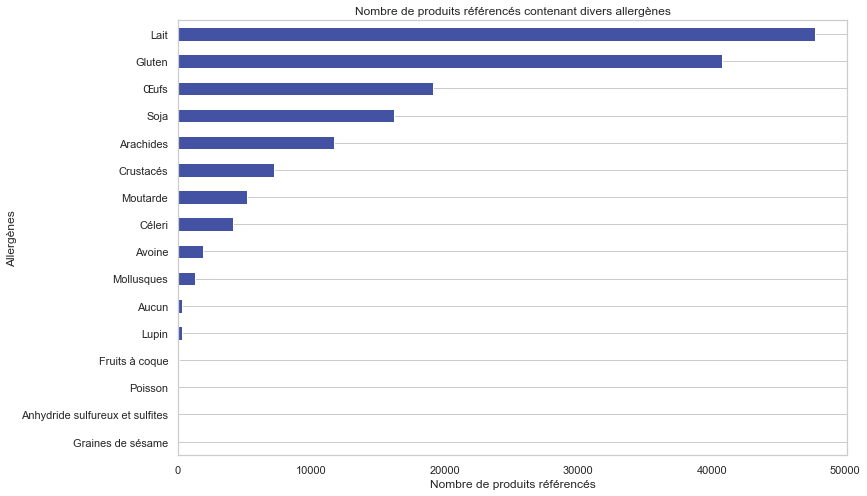

In [65]:
# Tracer un diagramme en bâtons des allergènes les plus courants
ax = allergens_occurences['count'].plot.barh(figsize=(12, 8), color='#4352a2')
ax.invert_yaxis()
ax.xaxis.grid()

plt.title('Nombre de produits référencés contenant divers allergènes')
plt.xlabel('Nombre de produits référencés')
plt.ylabel('Allergènes')
plt.show()

Les personnes intolérante au lactose et au gluten se voient privé d'une grande majorité de produits.

#### Résumé

Nous terminons notre deuxième thème d'analyse. Nous constatons que le lait et le gluten sont de loin les allergènes les plus courants. Les oeufs et le soja sont également courants. En creusant dans les données, nous pouvons constater que les sandwichs, les plats uniques et les aliments préparés en général contiennent le plus d'allergènes. Les boîtes de sushis peuvent contenir plus de 8 allergènes différents par exemple.

Pour une exploration plus approfondie, le Dataframe suivant permet de filtrer facilement les produits par allergènes (transformés en variables indicatrices) et fournit également le nombre d'allergènes par produit.

In [66]:
# Table pivot pour avoir une variable pour chaque taxonomie d'allergène. 
# avec True/False indiquant si le produit contient l'allergène correspondant
df_allergens_pivot = df_allergens[df_allergens.translated].pivot_table(index='code', 
                                                                       columns='allergen_translation', 
                                                                       values='translated',
                                                                       fill_value=False)

# Compter le nombre d'allergènes par produit
df_allergens_pivot['allergen_count'] = df_allergens_pivot.sum(axis=1)

# Récupérer la variable product_name en rejoignant le dataframe df_alergens
df_allergens_pivot = pd.concat([df_allergens_pivot, df.product_name], axis=1, join='inner')

# Réindexer les colonnes
cols = ['product_name', 'allergen_count'] + df_allergens_pivot.columns[0:13].values.tolist()
df_allergens_pivot = df_allergens_pivot.reindex(columns=cols)

# Exemple : Produits avec au moins 8 allergènes et qui contiennent du gluten
df_allergens_pivot[(df_allergens_pivot.allergen_count >= 8) & df_allergens_pivot['Gluten']]

,product_name,allergen_count,Anhydride sulfureux et sulfites,Arachides,Aucun,Avoine,Crustacés,Céleri,Fruits à coque,Gluten,Graines de sésame,Lait,Lupin,Mollusques,Moutarde
code,,,,,,,,,,,,,,,
2222604036607,Jarret de Porc Désossé et son Jus d'Échalotes ...,8.0,False,True,False,False,True,True,False,True,False,True,False,False,True
2446510034049,Barbajuan A Roca,10.0,False,True,False,False,True,True,False,True,False,True,True,True,True
3100080050074,Soupe bien-être bio giraudet,9.0,False,True,False,False,True,False,False,True,False,True,True,True,True
3240931536903,Lunch Box - Penne Saumon,9.0,False,True,False,False,True,True,False,True,False,True,False,True,True
3250390000266,Farine de blé type45,8.0,False,True,False,True,False,True,False,True,False,True,True,False,False
3250390102281,Farine fluide anti-grumeaux,8.0,False,True,False,True,False,True,False,True,False,True,True,False,False
3250390102298,Farine à Gâteaux,8.0,False,True,False,True,False,True,False,True,False,True,True,False,False
3250390787327,Tartiflette au reblochon de savoie label rouge,8.0,False,True,False,False,True,True,False,True,False,True,False,True,True
3250391054640,Coleslaw,9.0,False,False,False,True,True,True,False,True,False,True,False,True,True


De cette manière les agents peuvent facilement mener une étude sur les allergènes.